In [16]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, dates
import seaborn as sns
from datetime import datetime, date
import re
import glob
from scipy.stats import ttest_ind, wilcoxon

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

pd.options.mode.chained_assignment = None  # default='warn'

In [17]:
from google.colab import drive
drive.mount('/content/drive')

path_drive = 'drive/MyDrive/pc/viettel/pow/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# sb

In [19]:
# part
# path = r'G:\.shortcut-targets-by-id\16fk5oTyKTh5Xt29PZH6u56tipQMA3uRH\viettel\pow\data\parts_merged.xlsx'
path = path_drive + 'parts_merged.xlsx'
df_part = read_df_part(path)
print('df_part =', df_part.shape)

df_part = (122, 9)


In [20]:
# sootblowing
# path_gr2 = r'G:\.shortcut-targets-by-id\16fk5oTyKTh5Xt29PZH6u56tipQMA3uRH\viettel\pow\data\THOI BUI GR2 2023\*'
path_gr2 = path_drive + 'THOI BUI GR2 2023/*'
df_gr2 = read_data(path_gr2)
df_gr2.insert(0, 'group', 2)

# path_gr3 = r'G:\.shortcut-targets-by-id\16fk5oTyKTh5Xt29PZH6u56tipQMA3uRH\viettel\pow\data\THOI BUI GR3 2023\*'
path_gr3 = path_drive + 'THOI BUI GR3 2023/*'
df_gr3 = read_data(path_gr3)
df_gr3.insert(0, 'group', 3)

df_gr = pd.concat([df_gr2, df_gr3]).reset_index(drop=True)
print('df_gr =', df_gr.shape)

df_gr = preprocessing(df_gr, df_part)
print('df_gr =', df_gr.shape)

df_cycle = create_df_cycle(df_gr)
print('df_cycle =', df_cycle.shape)

# filter cycle with predefined step and having sootblowing time >= 5 min
df_cycle_filter = df_cycle[(df_cycle['step_str'].isin(step_filter)) & (df_cycle['time_sb_m'] >= 5)]
print('df_cycle_filter =', df_cycle_filter.shape)

df_filter = df_gr.merge(df_cycle_filter['cycle_gr'], how='inner', on='cycle_gr')
print('df_filter =', df_filter.shape)

# add cycle
df_filter = add_cycle(df_filter)
print('df_filter =', df_filter.shape)

# get start and stop time
df_filter_sorted = df_filter[df_filter['status']!='xs'].sort_values(by=['group', 'datetime'])
print('num cycle =', df_filter_sorted['cycle_full_gr'].nunique())

df_filter_sorted_start_stop = df_filter_sorted[
    (
        ((df_filter_sorted['cycle_full_gr'] - df_filter_sorted['cycle_full_gr'].shift(1)) > 0) |
        df_filter_sorted['cycle_full_gr'].shift(1).isnull()
    ) |
    (
        ((df_filter_sorted['cycle_full_gr'].shift(-1) - df_filter_sorted['cycle_full_gr']) > 0) |
        df_filter_sorted['cycle_full_gr'].shift(-1).isnull()
    )
]
print('df_filter_sorted_start_stop =', df_filter_sorted_start_stop.shape)

df_filter_sorted_start_stop['datetime_round'] = [x.round('5min') for x in df_filter_sorted_start_stop['datetime']]
df_filter_sorted_start_stop['time'] = df_filter_sorted_start_stop['datetime_round'].dt.strftime('%H:%M:%S')
df_sb = df_filter_sorted_start_stop[['group', 'datetime', 'date', 'time', 'cycle_full_gr', 'status']]
df_sb['gr_status'] = df_sb['group'].astype(str) + '_' + df_sb['status']
# df_sb['date'] = pd.to_datetime(df_sb['date'])
print('df_sb =', df_sb.shape)

df_gr = (22547, 13)
df_gr = (22547, 22)
df_cycle = (12392, 9)
df_cycle_filter = (8866, 9)
df_filter = (17994, 22)
df_filter = (17994, 26)
num cycle = 585
df_filter_sorted_start_stop = (1170, 26)
df_sb = (1170, 7)


In [21]:
df_cycle_filter.head()

,equipment_code,cycle_gr,step,step_str,xs,start,stop,time_xs_m,time_sb_m
0,20HCB10AT001,1,"[start, stop]","['start', 'stop']",NaT,2023-02-02 19:23:00+07:00,2023-02-02 19:33:44+07:00,NaN,10.733333
1,20HCB10AT001,2,"[xs, start, reverse, stop]","['xs', 'start', 'reverse', 'stop']",2023-02-04 09:59:12+07:00,2023-02-04 09:59:54+07:00,2023-02-04 10:06:56+07:00,0.700000,7.033333
2,20HCB10AT001,3,"[xs, start, stop]","['xs', 'start', 'stop']",2023-02-04 10:09:13+07:00,2023-02-04 10:09:27+07:00,2023-02-04 10:15:46+07:00,0.233333,6.316667
4,20HCB10AT001,5,"[start, stop]","['start', 'stop']",NaT,2023-02-04 17:27:55+07:00,2023-02-04 17:40:48+07:00,NaN,12.883333
6,20HCB10AT001,7,"[start, stop]","['start', 'stop']",NaT,2023-02-06 17:22:42+07:00,2023-02-06 17:33:34+07:00,NaN,10.866667


In [22]:
df_cycle_filter_by_cycle_full = create_df_cycle(df_filter, full_gr=True).groupby('cycle_full_gr').agg(
    num_cycle = ('cycle_gr', 'count'),
    num_equip = ('equipment_code', 'nunique'),
    start_min = ('start', 'min'),
    start_max = ('start', 'max'),
    stop_max = ('stop', 'max'),
    time_sb_m_mean = ('time_sb_m', 'mean'),
).reset_index()

df_cycle_filter_by_cycle_full['time_sb_m_total'] = (df_cycle_filter_by_cycle_full['stop_max'] - df_cycle_filter_by_cycle_full['start_min']).dt.seconds/60

df_cycle_filter_by_cycle_full.describe()

,cycle_full_gr,num_cycle,num_equip,time_sb_m_mean,time_sb_m_total
count,585.00000,585.000000,585.000000,585.000000,585.000000
mean,293.00000,15.155556,14.943590,11.085967,106.659516
std,169.01923,6.638003,6.376479,1.422657,44.321639
min,1.00000,1.000000,1.000000,5.100000,5.100000
25%,147.00000,11.000000,11.000000,10.312963,82.000000
50%,293.00000,15.000000,14.000000,10.916667,106.816667
75%,439.00000,21.000000,21.000000,11.771212,133.266667
max,585.00000,47.000000,24.000000,22.850000,307.150000


In [23]:
df_filter_sorted_start_stop.describe(include='all', datetime_is_numeric=True)

,group,datetime,id,6,9,11,date,month,hour,equipment_code,abbr,zone,status,status_next,status_previous,datetime_next,delta_datetime_next,datetime_previous,delta_datetime_previous,cycle,cycle_begin,cycle_gr,cycle_full,cycle_full_gr,cycle_zone,cycle_zone_gr,datetime_round,time
count,1170.000000,1170,1.170000e+03,1170,1170,1170,1170,1170,1170.000000,1170,892,1170,1170,1168,1169,1168,1168.000000,1169,1169.000000,1170,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000,1170,1170
unique,NaN,NaN,NaN,3,69,118,269,12,NaN,39,35,4,2,4,4,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208
top,NaN,NaN,NaN,FCS0219,20HCB40AT011MS,20HCB30AT010 SOOTBLOWER MV02= 1 old= 0 [ OFFUSER@HIS0262 ],2023-02-02,2023-05-01,NaN,20HCB40AT011,IK-8,PRIMARY SUPERHEATER,start,stop,start,NaN,NaN,NaN,NaN,end,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:05:00
freq,NaN,NaN,NaN,585,182,107,14,169,NaN,191,191,570,585,595,570,NaN,NaN,NaN,NaN,585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
mean,2.509402,2023-06-23 08:49:22.258974208+07:00,3.899721e+08,NaN,NaN,NaN,NaN,NaN,11.544444,NaN,NaN,NaN,NaN,NaN,NaN,2023-06-23 16:03:50.537671168+07:00,428.936030,2023-06-22 22:54:11.353293312+07:00,368.951640,NaN,0.452991,6423.788034,0.447863,293.000000,0.447863,548.518803,2023-06-23 08:49:20+07:00,NaN
min,2.000000,2023-01-31 00:32:23+07:00,3.142750e+08,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-31 00:42:32+07:00,0.016667,2023-01-31 00:42:32+07:00,0.033333,NaN,0.000000,2.000000,0.000000,1.000000,0.000000,1.000000,2023-01-31 00:30:00+07:00,NaN
25%,2.000000,2023-04-12 16:12:57.500000+07:00,3.514930e+08,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-13 10:47:43+07:00,10.783333,2023-04-12 01:31:36+07:00,9.850000,NaN,0.000000,2936.250000,0.000000,147.000000,0.000000,271.250000,2023-04-12 16:12:30+07:00,NaN
50%,3.000000,2023-06-11 00:11:06+07:00,3.819588e+08,NaN,NaN,NaN,NaN,NaN,16.000000,NaN,NaN,NaN,NaN,NaN,NaN,2023-06-11 20:52:04.500000+07:00,14.000000,2023-06-10 22:33:59+07:00,13.183333,NaN,0.000000,6406.000000,0.000000,293.000000,0.000000,543.000000,2023-06-11 00:10:00+07:00,NaN
75%,3.000000,2023-08-25 01:49:50+07:00,4.219710e+08,NaN,NaN,NaN,NaN,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-25 06:32:11.249999872+07:00,1246.679167,2023-08-24 22:19:45+07:00,715.783333,NaN,1.000000,10958.750000,1.000000,439.000000,1.000000,826.000000,2023-08-25 01:47:30+07:00,NaN
max,3.000000,2023-12-30 09:36:57+07:00,4.988957e+08,NaN,NaN,NaN,NaN,NaN,23.000000,NaN,NaN,NaN,NaN,NaN,NaN,2023-12-30 09:24:50+07:00,1439.933333,2023-12-30 09:25:35+07:00,1439.500000,NaN,1.000000,12285.000000,1.000000,585.000000,1.000000,1107.000000,2023-12-30 09:35:00+07:00,NaN


# 2023

In [24]:
# path = r"G:\.shortcut-targets-by-id\16fk5oTyKTh5Xt29PZH6u56tipQMA3uRH\viettel\pow\data\VA1_U2_2023_full.csv"
path = path_drive + 'VA1_U2_2023_full.csv'
# path = "D:/vts/pvp/0125_0127_2.csv"
df_raw = pd.read_csv(path)

<ipython-input-24-444e3fa2ad32>:4: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

In [25]:
df = df_raw.copy()
df.columns = [x.replace('\\\PIDATA\\VA1_U2_', '') for x in df.columns]
df['Time'] = pd.to_datetime(df['Time'])
df['date'] = df['Time'].dt.date
df['month'] = df['Time'].dt.month
# df['date'] = pd.to_datetime(df['date'])
df['time'] = df['Time'].dt.strftime('%H:%M:%S')
df['hour'] = df['Time'].dt.hour
print(df.shape)

time_cols = ['Time', 'date', 'month', 'time', 'hour']
print('time_cols =', len(time_cols))

tag_cols = [c for c in df.columns if c not in time_cols]

for c in tag_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df['RH_Spray_Flow'] = (df['P10RHWF_act'] + df['P20RHWF_act'])/df['MSF_act'] * 100
tag_cols = [c for c in df.columns if c not in time_cols]
print('tag_cols =', len(tag_cols))

df = df.merge(df_sb[df_sb['group']==2][['date', 'time', 'cycle_full_gr', 'status']].rename(columns={'cycle_full_gr': 'cycle_gr2', 'status': 'status_gr2'}), how='left', on=['date', 'time'])
df = df.merge(df_sb[df_sb['group']==3][['date', 'time', 'cycle_full_gr', 'status']].rename(columns={'cycle_full_gr': 'cycle_gr3', 'status': 'status_gr3'}), how='left', on=['date', 'time'])
gr_cols = ['status_gr2', 'status_gr3']
print('gr_cols =', len(gr_cols))

(105120, 359)
time_cols = 5


<ipython-input-25-c183d91baf7b>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['RH_Spray_Flow'] = (df['P10RHWF_act'] + df['P20RHWF_act'])/df['MSF_act'] * 100


tag_cols = 355
gr_cols = 2


In [26]:
def c2f(t):
   return (1.8 * t) + 32.

def noi_suy(X,y,Z,n):
  if X < y[0]:
    return Z[0]
  else:
    if X > y[n]: return Z[n]
    else:
      i = 1
      while X > y[i]:
        i+=1
      return (Z[i] - Z[i-1]) / (y[i] - y[i-1]) * (X - y[i-1]) + Z[i-1]

def noi_suy_df(x_df, y, Z, n):
  return x_df.apply(lambda x: noi_suy(x, y, Z, n))

mst_hr = 0.15/100
mst_chg = 10
rht_hr = 0.14/100
rht_chg = 10
rhs_hr = 0.20/100
rhs_chg = 1
got_hr = 0.30/100
got_chg = 10

hshc_p_load = [60,65,70,75,80,85,90,95,100]
hshc_heat_rate = [ 10798 , 10649 , 10406 , 10303 , 10254 , 10141 , 10062 , 9995 , 9939 ]

ah_t_load = [60,75,100]
ahagot_t = [109.2546,114.69,123.749]
ahbgot_t = [124.272,127.86,133.84]

# GENP_act
genp = df['GENP_act']

#HR target
hr_target = noi_suy_df(genp/6.0, hshc_p_load, hshc_heat_rate,8)

#AH GOT target
ahagot_target = noi_suy_df(genp/6.0, ah_t_load, ahagot_t, 2)
ahbgot_target = noi_suy_df(genp/6.0, ah_t_load, ahbgot_t, 2)

# SH Steam temp.
df['hr_shst'] = (df['MST_act'].apply(lambda x: c2f(x))-c2f(538)) * mst_hr / mst_chg * hr_target
# RH Steam temp.
df['hr_rhst'] = (df['HRHT_act'].apply(lambda x: c2f(x))-c2f(538)) * rht_hr / rht_chg * hr_target
# RH spray flow
## = (P10RHWF_act + P20RHWF_act)/ (MSF_act) * 100
df['hr_rhsf'] = (df['P10RHWF_act'] + df['P20RHWF_act'])/df['MSF_act'] * 100 * rhs_hr / rhs_chg * hr_target
# AH A Gas Out Temp.
df['hr_aha'] = (df['AHAGOT_act'].apply(lambda x: c2f(x)) - c2f(ahagot_target)) * got_hr/ got_chg * hr_target
# AH B Gas Out Temp.
df['hr_ahb'] = (df['AHBGOT_act'].apply(lambda x: c2f(x)) - c2f(ahbgot_target)) * got_hr/ got_chg * hr_target

df['hr'] = df['hr_shst'] + df['hr_rhst'] + df['hr_rhsf'] + df['hr_aha'] + df['hr_ahb']

df.shape

<ipython-input-26-a7fc26936f89>:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['hr_shst'] = (df['MST_act'].apply(lambda x: c2f(x))-c2f(538)) * mst_hr / mst_chg * hr_target
<ipython-input-26-a7fc26936f89>:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['hr_rhst'] = (df['HRHT_act'].apply(lambda x: c2f(x))-c2f(538)) * rht_hr / rht_chg * hr_target
<ipython-input-26-a7fc26936f89>:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

(105120, 370)

In [27]:
var = '''MST_act
RHST_act
RH_Spray_Flow
AHAGOT_act
AHBGOT_act
AHAGIT_act
AHBGIT_act'''.split(sep='\n')
# SHST_act
# RHSWT_act
# TotCOAL_act
# BART_act

var = var + ['hr', 'hr_shst', 'hr_rhst', 'hr_rhsf', 'hr_aha', 'hr_ahb']

var_name = '''Nhiệt độ hơi chính (°C)
Nhiệt độ hơi ra tái nhiệt (°C)
RH_Spray_Flow (%)
Nhiệt độ khói ra AH.A (°C)
Nhiệt độ khói ra AH.B (°C)
Nhiệt độ khói vào AH.A (°C)
Nhiệt độ khói vào AH.B (°C)'''.split(sep='\n')
# Nhiệt độ nước phun giảm ôn bộ quá nhiệt
# Nhiệt độ nước phun giảm ôn bộ tái nhiệt
# Tổng lưu lượng than cấp vào lò (kg/s)
# Nhiệt độ môi trường

var_name = var_name + ['HR effect', 'HR effect SH Steam Temp', 'HR effect RH Steam Temp', 'HR effect RH Spray Flow', 'HR effect AH A Gas Out Temp', 'HR effect AH B Gas Out Temp']

In [28]:
df[var].describe(include='all', datetime_is_numeric=True)

,MST_act,RHST_act,RH_Spray_Flow,AHAGOT_act,AHBGOT_act,AHAGIT_act,AHBGIT_act,hr,hr_shst,hr_rhst,hr_rhsf,hr_aha,hr_ahb
count,105107.000000,105107.000000,105107.000000,105107.000000,105107.000000,105107.000000,104774.000000,105107.000000,105107.000000,105107.000000,105107.000000,105107.000000,105107.000000
mean,442.382872,446.006377,0.589459,103.874739,110.469627,293.809726,296.925765,-700.769671,-278.431386,-249.928952,12.480260,-75.529813,-109.359780
std,188.193870,181.065228,128.840564,38.627027,41.492461,130.717616,131.422161,3141.435855,548.829475,492.879147,2782.441202,203.958511,226.882815
min,22.103154,0.000000,-21506.990708,16.037181,15.521014,16.479102,15.871253,-465128.582190,-1504.076620,-1463.949648,-464464.971331,-543.543315,-634.118302
25%,529.827224,526.682926,0.018154,112.697331,122.387054,335.989908,340.323532,-88.456053,-22.056807,-29.239729,0.381427,-39.719682,-35.214590
50%,535.541235,534.083746,0.225096,120.429387,129.403874,357.101924,360.035511,-4.232133,-6.686857,-10.001442,4.560100,10.888410,-4.392231
75%,538.459867,537.062663,0.426873,126.602982,133.856751,367.879567,370.138433,54.667307,1.282502,-2.413177,8.670031,42.297199,15.805390
max,551.599338,545.149596,30367.924694,169.861634,149.997175,398.235837,404.406897,655170.153970,39.287300,18.940652,655825.701693,353.394765,150.001440


In [37]:
np.sort(df[df['MST_act'] < 500]['date'].unique())

array([datetime.date(2023, 1, 9), datetime.date(2023, 1, 12),
       datetime.date(2023, 1, 15), datetime.date(2023, 1, 16),
       datetime.date(2023, 1, 17), datetime.date(2023, 1, 18),
       datetime.date(2023, 1, 19), datetime.date(2023, 1, 20),
       datetime.date(2023, 1, 21), datetime.date(2023, 1, 22),
       datetime.date(2023, 1, 23), datetime.date(2023, 1, 24),
       datetime.date(2023, 1, 25), datetime.date(2023, 1, 26),
       datetime.date(2023, 1, 27), datetime.date(2023, 1, 28),
       datetime.date(2023, 1, 29), datetime.date(2023, 2, 9),
       datetime.date(2023, 2, 12), datetime.date(2023, 3, 9),
       datetime.date(2023, 3, 12), datetime.date(2023, 4, 9),
       datetime.date(2023, 4, 12), datetime.date(2023, 5, 9),
       datetime.date(2023, 5, 12), datetime.date(2023, 6, 9),
       datetime.date(2023, 6, 12), datetime.date(2023, 7, 9),
       datetime.date(2023, 7, 12), datetime.date(2023, 8, 9),
       datetime.date(2023, 8, 12), datetime.date(2023, 8, 26),


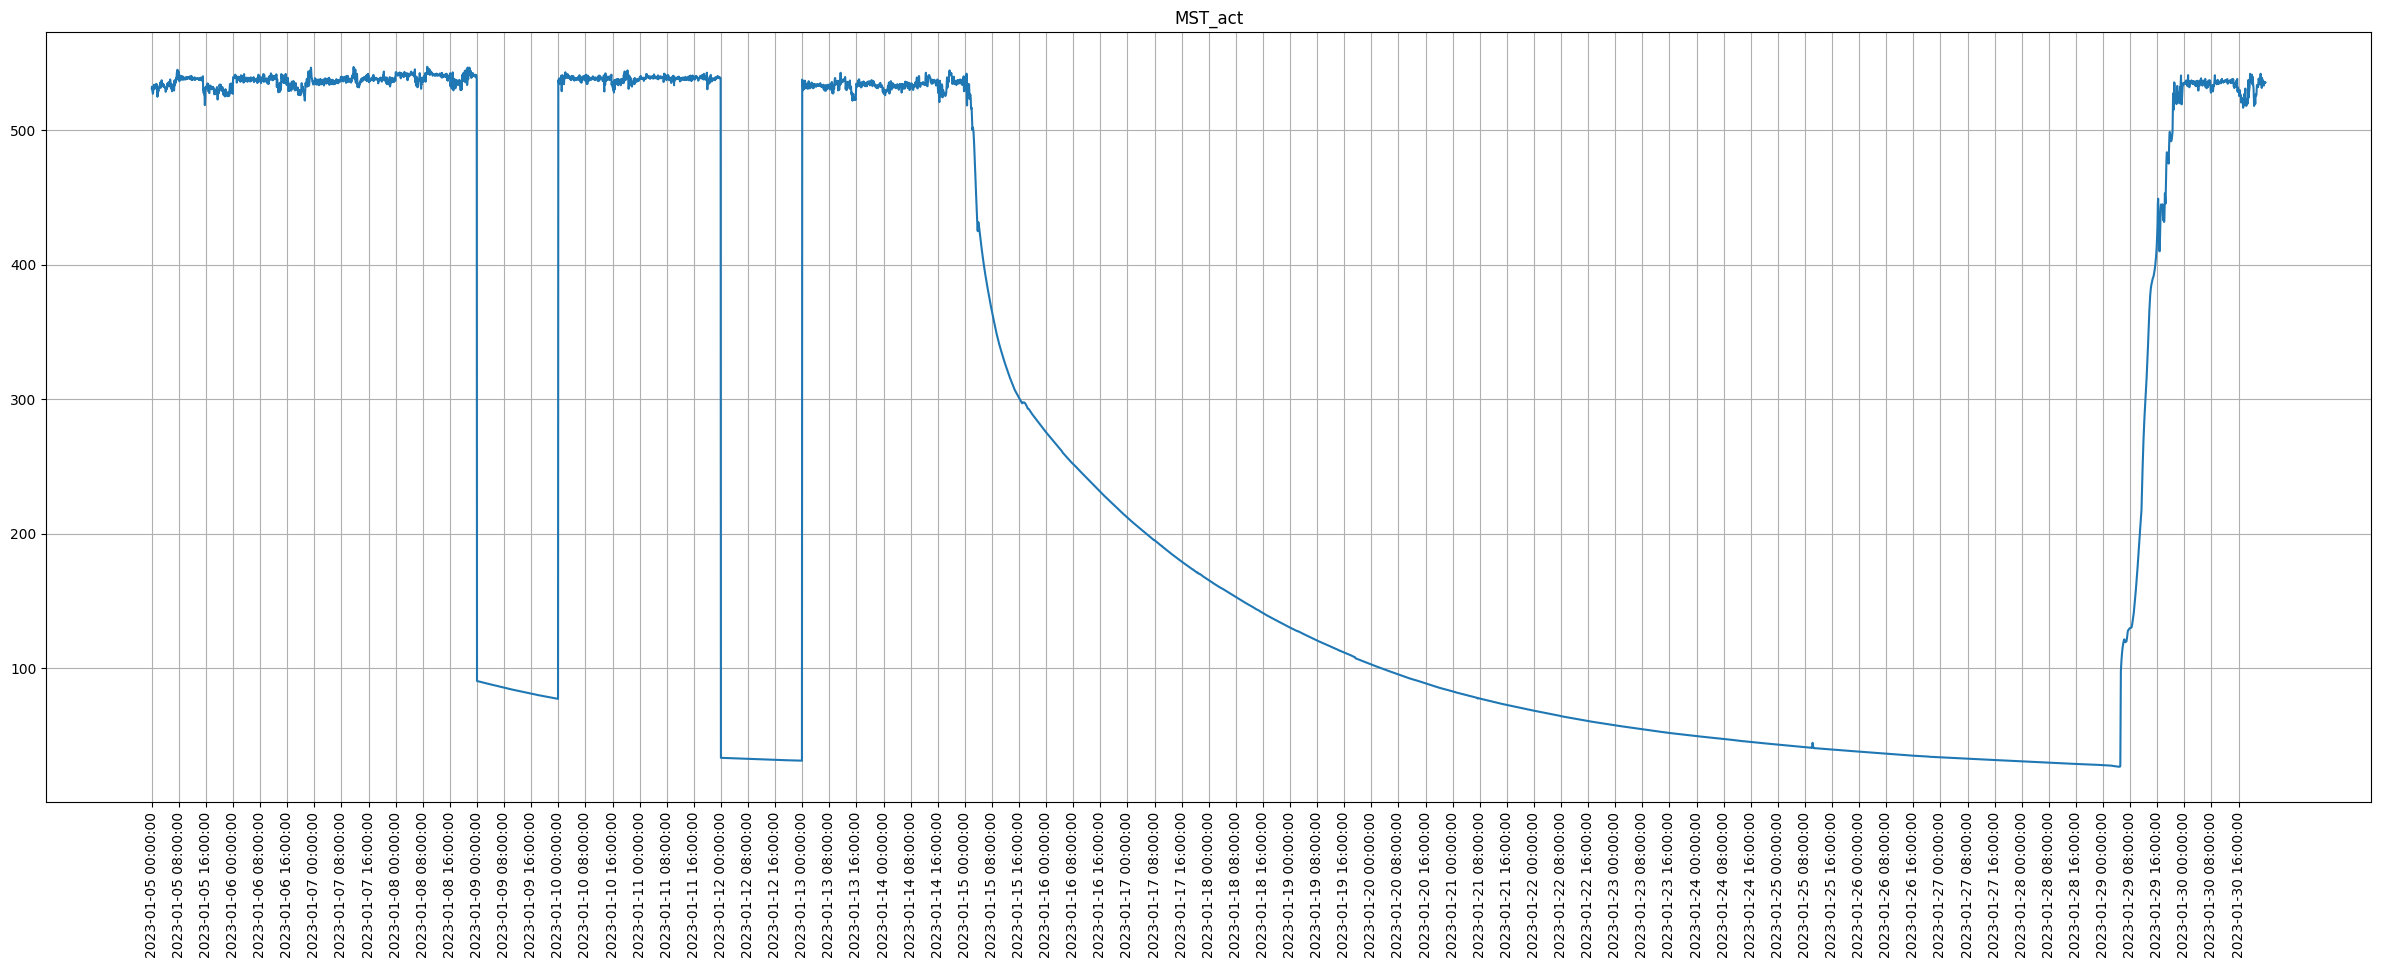

In [42]:
x = 'MST_act'
date_begin = '2023-01-05'
date_end = '2023-01-30'

df_plot = df[(df['date'].astype(str)>=date_begin) & (df['date'].astype(str)<=date_end)].sort_values(by='Time').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(30,10))
ax.plot(df_plot['Time'].astype(str), df_plot[x], label=x)
ax.set_xticks(ax.get_xticks()[::96])
plt.xticks(rotation=90)
plt.grid()
plt.title(x)
plt.show()